# Analysis of different regression methods.

Analysis will be done separately on two time classes that have been discussed, that is regression models will be separately tested on T<0.35 and on T>0.35 time-series. Finally, a full predictive model will be tested.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import tensorflow as tf 
import h5py
import random
import time
from math import *
import copy

%run Network.ipynb

import warnings
warnings.filterwarnings('ignore')

In [3]:
f=h5py.File("PCA_params.hdf5","r")
P=f['Parameters']
T=f['Time']
N=len(T)

P=np.array(P)
T=np.array(T)

P_above=[]
P_below=[]
T_above=[]
T_below=[]

for i in range(N):
    if T[i]<=0.35:
        P_below.append(P[i])
        T_below.append(T[i])
    else:
        P_above.append(P[i])
        T_above.append(T[i])

P_above=np.array(P_above)
P_below=np.array(P_below)
T_above=np.array(T_above)
T_below=np.array(T_below)

f.close()

---

## T<0.35 time class

Models that will be explored are: 
- support vector machine regression
- neural network
- k-nearest neighbors

### SVM regression

Given small number of data points in this class, we will simply use one set of test data (without a validation set).

In [4]:
P_train_below,P_test_below,T_train_below,T_test_below=train_test_split(P_below,T_below,test_size=0.2)

Like with classification, rbf kernel is used. Parameters were chosen using a grid search - small epsilon shows, that a small margin for penalization helps improving accuracy of this regressor. We define our own scoring function.

In [4]:
def score_svm(classifier,test_data,test_values):
    return np.mean(np.absolute(classifier.predict(test_data)-test_values))

In [5]:
clf_below=SVR(kernel="rbf",gamma=0.06,C=0.64,epsilon=0.001)
clf_below.fit(P_train_below,T_train_below)

SVR(C=0.64, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma=0.06,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [6]:
print('Test score is {:.4f}'.format(score_svm(clf_below,P_test_below,T_test_below)))
print('Training score is {:.4f}'.format(score_svm(clf_below,P_train_below,T_train_below)))

Test score is 0.0120
Training score is 0.0076


(0, 0.4)

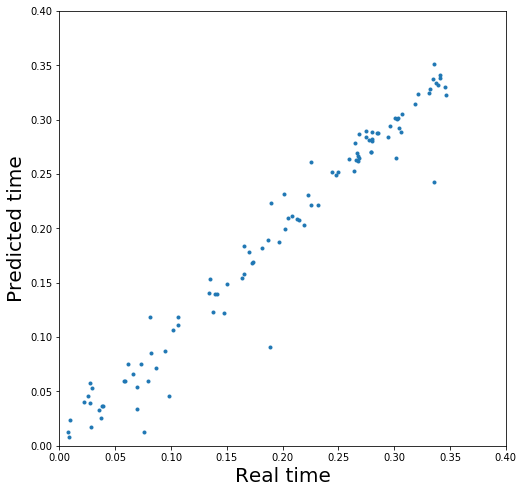

In [7]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test_below,clf_below.predict(P_test_below),'.')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,0.4))
ax.set_ylim((0,0.4))

Figure above shows that predictions are pretty good, and most errors come from time series with lowest T. That's where the signal stops having distinct signatures.

### Neural Network regression

Here, a neural network will be built with 2 hidden layers.

In [8]:
layers=[P_below.shape[1],25,10,1]
batch_size=10
n_epochs=1000
learning_rate=0.05
fl_name='low_time_regressor'

In [9]:
net_below=Network(layers,batch_size,fl_name,regression=True)
net_below.create_network(learning_rate,activ="SIG")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
net_below.train(P_train_below,T_train_below,P_test_below,T_test_below,n_epochs,save_model=True)

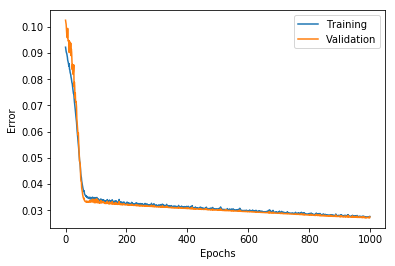

In [11]:
net_below.plot_error()

The network seems to not perform as well as SVM.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./low_time_regressor.ckpt


(0, 0.4)

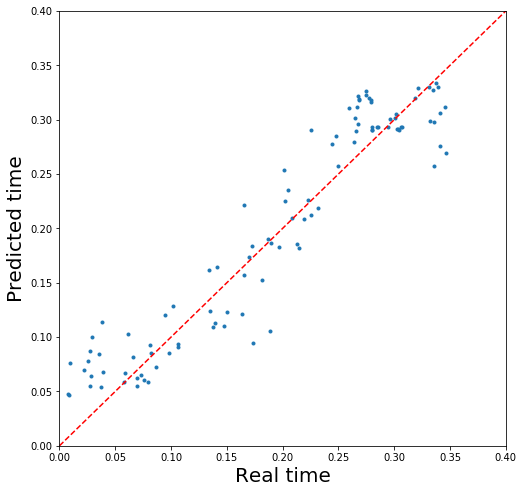

In [12]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test_below,net_below.predict(P_test_below),'.')
ax.plot([0,0.4],[0,0.4],'r--')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,0.4))
ax.set_ylim((0,0.4))

### k-Nearest Neighbors classifier

For this classifier, we define functions ourselves.

In [31]:
def distance(va,vb,ps,kernel="E",gamma=0.05): #Definition of distance using given parameters.

    dist=0

    for k in range(len(va)):
        dist+=ps[k]*(va[k]-vb[k])**2
    
    if kernel=="G":
        return math.exp(-gamma*dist)
    elif kernel=="E":
        return math.sqrt(dist)

def estimate(ind,training_data,test_data,time_data,ps,k,weighted,train=False,kernel="E"):
                                                            #This function calculates distances between parameters' vector of 
                                                            #index "ind" and vectors with indices from list. Next,
                                                            #the list of tuples (distance,index) is sorted by the distance and
                                                            #time to event of the "ind" vector is etimated using "k" closest
                                                            #vectors. If "weighted" is set to True, estimate is done using a 
                                                            #weighted average with weight=1/distance. 
    if train:
        indices=[i for i in range(len(training_data)) if i!=ind] 
        v_est=training_data[ind]
    else:
        indices=[i for i in range(len(training_data))]
        v_est=test_data[ind]
        
    
      
    dists=[]
    
    for i in indices:
        dists.append((distance(v_est,training_data[i],ps,kernel=kernel),i))

    dists=sorted(dists,key=lambda x: x[0])


    estimate=0
    if weighted:
        weight=0
        for i in range(k):
            if dists[i][0]==0:
                d=0.001
            else:
                d=dists[i][0]
            estimate+=time_data[dists[i][1]]/d
            weight+=1/d
        
        if weight==0:
            weight=0.001
            
        return estimate/weight
    else:
        for i in range(k):
            
            estimate+=time_data[dists[i][1]]

        return estimate/k


def score(ind,time_data,est):           #Simply returns error of the estimate for a single sample vector.
    return abs(time_data[ind]-est)


def get_training_score(training_data,time_data,ps,k):   #Calculates score (error) for a training sample.  
                                            
    scr=0
    k=int(k)

    for i in range(len(training_data)):

        est=estimate(i,training_data,[],time_data,ps,k,True,train=True)
        scr+=score(i,time_data,est)

    return scr/len(training_data)


def get_validation_error(training_data,test_data,train_time_data,test_time_data,ps,k):  #Calculates score (error) for a test sample. It estimates time
                                                                #to event for vectors with indecies in "test_sample" using
                                                                #vectors with indecies in "training_sample".
    validate_error=0
    k=int(k)
    for i in range(len(test_data)):
        est=estimate(i,training_data,test_data,train_time_data,ps,k,True)
        validate_error+=score(i,test_time_data,est)

    return validate_error/len(test_data)

<b>k-Nearest Neighbors trained using genetic optimization</b>

Algorithm is quite long, so let me first explain what I'm trying to do here...

The genetic optimization algorithm works by first creating a population, where every member of the population is a vector containing optimized parameters. Here, such a member has 11 parameters used to calculate the distance between two vectors, plus an additional parameter <b>k</b> telling us how many nearest neighbors to use. Every parameter has a lower and upper bound definied by an array <b>Domain</b>.

First, I generate <b>popsize</b> number of members of the population (<b>pop</b>). For every member I calculate score (error) for the test sample using the training sample. Afterwards, I sort the population in ascending order (the smaller the error, the better) and choose only <b>elite</b> number of top members. At the end of iteration, I create <b>popsize</b>-<b>elite</b> number of new members by either: mutation or crossover of the top <b>elite</b> members of the population.

List <b>probabilities</b>defines probabilities of different kind of mutations/crossovers occuring: if generated random number is smaller than <b>probabilities[0]</b> , then mutation happens only at one random parameter, if it is between <b>probabilities[0]</b> and <b>probabilities[1]</b>, it occurs at random parameters, and so on. If the random number is between <b>probabilities[11]</b> and <b>probabilities[12]</b>, a fully new vector is created. Finally, for random numbers bigger than <b>probabilities[12]</b> crossover occurs. Mutation is process, where random parameter(s) are changed by a small random fraction of its(their) allowed domain. Crossover combines two vectors at a random point. This process is repeated <b>iterations</b> number of times for one instance of resampling.

Finally, the process is started all over from the beginning <b>optimizations</b> number of times. After each run, the final best members of the population are added to final population. The whole function returns array contatining training and test errors for all the optimization processes, final training errors for the final population, and the top 5 parameters' vectors.

In [34]:
def optimize_knns(training_data,test_data,train_time_data,test_time_data,popsize=50,iterations=50,optimizations=3):

    #Samples for  training and testing
    
    Training_errors=np.zeros((iterations,optimizations))    
    Test_errors=np.zeros((iterations,optimizations))
    Fin_training_errors=np.zeros(2*iterations)
    Fin_test_errors=np.zeros(2*iterations)

    N_pars=11+1 #Number of optimized parameters

    
    
    #Domain for optimized parameters
    
    Domain=np.zeros((N_pars,2))
    for i in range(N_pars):
        Domain[i,1]=10

    Domain[N_pars-1,1]=15
    Domain[N_pars-1,0]=1

    
    
    #Fraction of population being saved for the next iteration and used to create offspring
    
    elite_frac=0.25

    elite=int(elite_frac*popsize)

    
    
    #Probabilities of mutations and crossovers
    
    probabilities=[0]*13

    probabilities[0]=0.2 #20% for mutating one random parameter
    probabilities[1]=0.3 #10% for mutating two random parameters
    probabilities[2]=0.38 #8% for 3
    probabilities[3]=0.44 #6% for 4
    probabilities[4]=0.49 #5% for 5
    probabilities[5]=0.53 #4% for 6
    probabilities[6]=0.55 #2% for 7
    probabilities[7]=0.56 #1% for 8
    probabilities[8]=0.57 #1% for 9
    probabilities[9]=0.58 #1% for 10
    probabilities[10]=0.59 #1% for 11
    probabilities[11]=0.595 #0.5% for mutating all 12 parameters
    probabilities[12]=0.62 #2.5% to create totally new 12 parameters
                           #38% for crossover
        
        
        
    #Best training score (lowest error) and corresponding parameters will be saved here
    
    best=[0]*(N_pars+1)
    best[-1]=10**6


    
    #Final population container
    
    final_pop=np.zeros((popsize,N_pars))

    

    #Optimization starts here
    
    for l in range(optimizations):   #This loops over number of times the whole process starts from a new random population
       
        print("Population",l+1)

        
        #Creating random population
        
        pop=np.zeros((popsize,N_pars))  #Container for the population
        
        for i in range(popsize):  #Every parameter is chosen randomly between its lower and upper bounds
            for j in range(N_pars):
                pop[i,j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]
            pop[i,N_pars-1]=random.randint(Domain[N_pars-1,0],Domain[N_pars-1,1])

            
        for i in range(iterations): #This loops over number of times scores are calculated for the same train and test
                                        #samples and population is evolved.

            print("Iteration",i+1)



            #Calculating scores for training

            scores=np.zeros((popsize,N_pars+1))
            scores[:,0:N_pars]=pop   #First N_pars elements of a row are just parameters in the population, the last 
                                             #element will be the score

            for j in range(popsize):

                scores[j,N_pars]=get_training_score(training_data,train_time_data,pop[j,0:11],pop[j,11])

            scores=np.array(sorted(scores,key=lambda x: x[-1]))  #Sorting with respect to obtained scores

            if scores[0,N_pars]<best[-1]:
                best=scores[0]
                print("Best parameters (training):")
                print(best)

            Training_errors[i,l]=scores[0,N_pars]



            #Calculating scores for monitoring progress using initially removed test sample

            tst_score=get_validation_error(training_data,test_data,train_time_data,test_time_data,scores[0,0:11],scores[0,11]) 

            Test_errors[i,l]=tst_score


            #Creating offspring.

            pop=scores[0:elite,:N_pars]   #We leave only the top "elite" number of members.                 

            while len(pop[:,0])<popsize:

                #First we check how many and which parameters will be mutated

                pr=random.random()

                if pr<probabilities[N_pars-1]:  
                    if pr<probabilities[0]:
                        C=[random.randint(0,N_pars-1)]
                    else:
                        for k in range(1,N_pars+1):
                            if pr<probabilities[k] and pr>probabilities[k-1]:

                                if k==N_pars:
                                    C=range(N_pars)
                                else:
                                    C=random.sample(range(N_pars),k)

                #Next, we select random remaining member of the population to be mutated. Deepcopy seems to be needed to 
                #avoid modifying the original element.

                    vec=copy.deepcopy(pop[random.randint(0,elite-1),:])

                #We mutate it. Mutated parameter can be changed by 2% of its allowed interval at most, with the parameter
                #"k" being an exception.

                    for c in C:

                        if c==N_pars-1:
                            vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0])) #Mutation of "k"
                        else:
                            vec[c]=vec[c]+(2*random.random()-1)*0.02*(Domain[c,1]-Domain[c,0])

                        if vec[c]<Domain[c,0]:
                            vec[c]=Domain[c,0]
                        if vec[c]>Domain[c,1]:
                            vec[c]=Domain[c,1]

                #New vector is added to population

                    pop=np.vstack((pop,vec))

                #We can also create a vector with completely new random parameters

                elif pr<probabilities[-1]:
                    vec=np.zeros(N_pars)

                    for j in range(N_pars):
                        if j==N_pars-1:
                            vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                        else:
                            vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                    pop=np.vstack((pop,vec))

                #Finally, we can mix two other vectors to create a new one.

                else:

                    c1=random.randint(0,elite-1)   
                    c2=random.randint(0,elite-1)   
                    vec1=pop[c1,:]                  #First random vector from top members
                    vec2=pop[c2,:]                  #Second random vector from top members
                    r=random.randint(1,N_pars)      #Index at which vectors are joined.
                    vec=np.concatenate((vec1[:r],vec2[r:]),axis=None) #Joined vector.

                    pop=np.vstack((pop,vec))
                

#At the end of optimization loop, the best results (members) are added to the final population
     
    final_pop[l*(1+int(elite/optimizations)):(l+1)*(1+int(elite/optimizations)),:]=pop[:(1+int(elite/optimizations)),:]
        
    #First, the population is replenished.
    
    if optimizations>0:
        pop=final_pop[:elite,:]

        while len(pop[:,0])<popsize:

            pr=random.random()

            if pr<probabilities[N_pars-1]:
                if pr<probabilities[0]:
                    C=[random.randint(0,N_pars-1)]
                else:
                    for k in range(1,N_pars+1):
                        if pr<probabilities[k] and pr>probabilities[k-1]:
                                
                            if k==N_pars:
                                C=range(N_pars)
                            else:
                                C=random.sample(range(N_pars),k)
                vec=copy.deepcopy(pop[random.randint(0,elite-1),:])
                for c in C:
                    if c==N_pars-1:
                        vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0]))
                    else:
                        vec[c]=vec[c]+(2*random.random()-1)*0.04*(Domain[c,1]-Domain[c,0])

                    if vec[c]<Domain[c,0]:
                        vec[c]=Domain[c,0]
                    if vec[c]>Domain[c,1]:
                        vec[c]=Domain[c,1]

                pop=np.vstack((pop,vec))


            elif pr<probabilities[-1]:
                vec=np.zeros(N_pars)

                for j in range(N_pars):
                    if j==N_pars-1:
                        vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                    else:
                        vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                pop=np.vstack((pop,vec))

            else:

                c1=random.randint(0,elite-1)
                c2=random.randint(0,elite-1)
                vec1=pop[c1,:]
                vec2=pop[c2,:]
                r=random.randint(1,N_pars)
                vec=np.concatenate((vec1[:r],vec2[r:]),axis=None)
                pop=np.vstack((pop,vec))

        #Now, once population has "popsize" members, final 2*"iterations" iterations are performed.
        

        for i in range(2*iterations):

            print("Iteration",i+1)
            
            
            scores=np.zeros((popsize,N_pars+1))
            scores[:,0:N_pars]=pop
            
            for j in range(popsize):

                scores[j,N_pars]=get_training_score(training_data,train_time_data,pop[j,0:11],pop[j,11])
            
            
            scores=np.array(sorted(scores,key=lambda x: x[-1]))

          
            if scores[0,N_pars]<best[-1]:
                best=scores[0]
                print("Best parameters:")
                print(best)

            Fin_training_errors[i]=scores[0,N_pars]
            
            tst_score=get_validation_error(training_data,test_data,train_time_data,test_time_data,scores[0,0:11],scores[0,11]) 

            Fin_test_errors[i]=tst_score

            pop=scores[0:elite,:N_pars]

            while len(pop[:,0])<popsize:

                pr=random.random()

                if pr<probabilities[N_pars-1]:
                    if pr<probabilities[0]:
                        C=[random.randint(0,N_pars-1)]
                    else:
                        for k in range(1,N_pars+1):
                            if pr<probabilities[k] and pr>probabilities[k-1]:
                                    
                                if k==N_pars:
                                    C=range(N_pars)
                                else:
                                    C=random.sample(range(N_pars),k)

                    vec=copy.deepcopy(pop[random.randint(0,elite-1),:])

                    for c in C:
                        if c==N_pars-1:
                            vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0]))
                        else:
                            vec[c]=vec[c]+(2*random.random()-1)*0.05*(Domain[c,1]-Domain[c,0])

                        if vec[c]<Domain[c,0]:
                            vec[c]=Domain[c,0]
                        if vec[c]>Domain[c,1]:
                            vec[c]=Domain[c,1]

                    pop=np.vstack((pop,vec))

                elif pr<probabilities[-1]:
                    vec=np.zeros(N_pars)

                    for j in range(N_pars):
                        if j==N_pars-1:
                            vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                        else:
                            vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                    pop=np.vstack((pop,vec))

                else:

                    c1=random.randint(0,elite-1)
                    c2=random.randint(0,elite-1)
                    vec1=pop[c1,:]
                    vec2=pop[c2,:]
                    r=random.randint(1,N_pars)
                    vec=np.concatenate((vec1[:r],vec2[r:]),axis=None)
                    pop=np.vstack((pop,vec))


    print("Best training parameters found:")
    print(best)

    return Training_errors,Test_errors,Fin_training_errors,Fin_test_errors,scores[:5]


In [35]:
TrE,TsE,FTrE,FTsE,Sc=optimize_knns(P_train_below,P_test_below,T_train_below,T_test_below,popsize=20,iterations=10,optimizations=2)

Population 1
Iteration 1
Best parameters (training):
[1.99390379 3.73705179 8.39549768 3.37151424 6.44970119 4.30423164
 6.1777254  4.74692371 4.75415795 4.78891106 0.60044605 2.
 0.01308356]
Iteration 2
Best parameters (training):
[6.57228171 8.58911948 4.63168585 5.3995342  6.12303932 6.51027001
 0.27896272 5.23798806 7.45903044 7.40997518 9.83886072 2.
 0.01279091]
Iteration 3
Best parameters (training):
[6.57228171 8.58911948 4.63168585 5.3995342  6.12303932 6.51027001
 0.27896272 5.23798806 7.45903044 7.40997518 9.95579841 2.
 0.01278553]
Iteration 4
Best parameters (training):
[1.99390379 3.73705179 4.63168585 5.3995342  6.12303932 6.51027001
 0.27896272 5.23798806 7.45903044 7.40997518 9.95579841 2.
 0.01254218]
Iteration 5
Best parameters (training):
[1.99390379 3.73705179 4.63168585 3.20919892 6.44970119 4.30423164
 0.27896272 5.23798806 7.45903044 7.40997518 9.83886072 2.
 0.01193048]
Iteration 6
Best parameters (training):
[1.99390379 3.73705179 4.63168585 3.20919892 6.44970

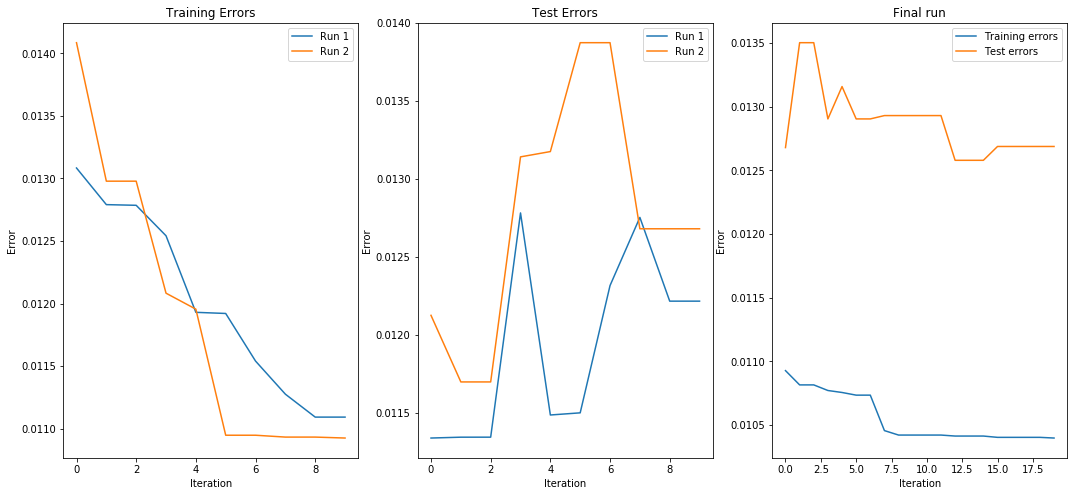

In [37]:
fig,ax=plt.subplots(1,3,figsize=(18,8))

ax[0].plot(TrE[:,0],label="Run 1")
ax[0].plot(TrE[:,1],label="Run 2")
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].set_title('Training Errors')
ax[0].legend()

ax[1].plot(TsE[:,0],label="Run 1")
ax[1].plot(TsE[:,1],label="Run 2")
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Error')
ax[1].set_title('Test Errors')
ax[1].legend()

ax[2].plot(FTrE,label="Training errors")
ax[2].plot(FTsE,label="Test errors")
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Error')
ax[2].set_title('Final run')
ax[2].legend()

This method yields results very close to ones obtained via SVM. Interestingly, it is optimal to use just the closest neighbor.

In [40]:
Estimates=np.zeros((len(P_test_below),))
for i in range(len(P_test_below)):
    Estimates[i]=estimate(i,P_train_below,P_test_below,T_train_below,Sc[0,:11],int(Sc[0,11]),True)

(0, 0.4)

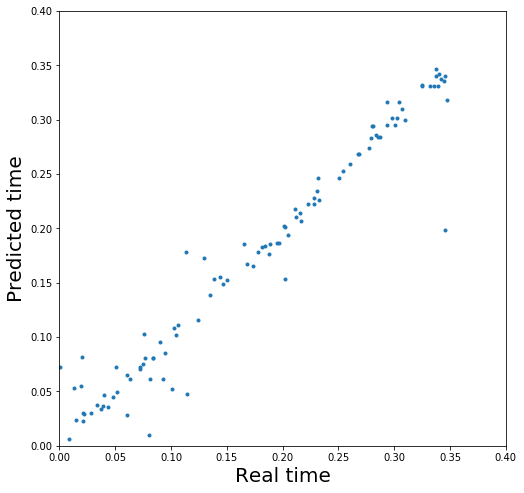

In [43]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test_below,Estimates,'.')
# ax.plot([0,0.4],[0,0.4],'r--')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,0.4))
ax.set_ylim((0,0.4))

---

## T>0.35

Here, only neural network and SVM will be tested.

### SVM regression

In [5]:
P_train_above,P_test_above,T_train_above,T_test_above=train_test_split(P_above,T_above,test_size=0.2)

Like with classification, rbf kernel is used. Parameters were chosen using a grid search.

In [21]:
clf_above=SVR(kernel="rbf",gamma=1,C=2,epsilon=0.01)
clf_above.fit(P_train_above,T_train_above)

SVR(C=2, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
print('Test score is {:.4f}'.format(score_svm(clf_above,P_test_above,T_test_above)))
print('Training score is {:.4f}'.format(score_svm(clf_above,P_train_above,T_train_above)))

Test score is 1.6609
Training score is 0.7086


We can see that the performance isn't that bad, though definitely the SVM overfit the training data. We see that predicted time is on average larger than real time for smaller T (below ~6), and smaller for larger T (above 10 or so).

(0, 16)

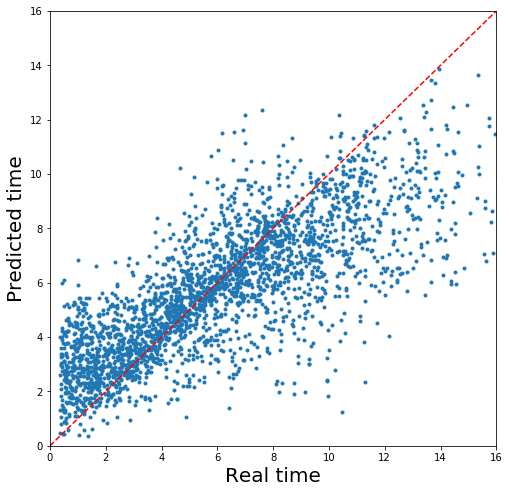

In [28]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test_above,clf_above.predict(P_test_above),'.')
ax.plot([0,16],[0,16],'r--')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,16))
ax.set_ylim((0,16))

### Neural Network regression

Here, a neural network will be built with 2 hidden layers. Identical to low-T one.

In [6]:
layers=[P_above.shape[1],100,250,100,80,30,1]
batch_size=25
n_epochs=1000
learning_rate=0.025
fl_name='high_time_regressor'

In [7]:
net_above=Network(layers,batch_size,fl_name,regression=True)
net_above.create_network(learning_rate,activ="SIG")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
net_above.train(P_train_above,T_train_above,P_test_above,T_test_above,n_epochs,save_model=True)

In [ ]:
net_above.plot_error()

The network seems to not perform as well as SVM on the test set, although performs better on the training set (overfitting).

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./high_time_regressor.ckpt


(0, 16)

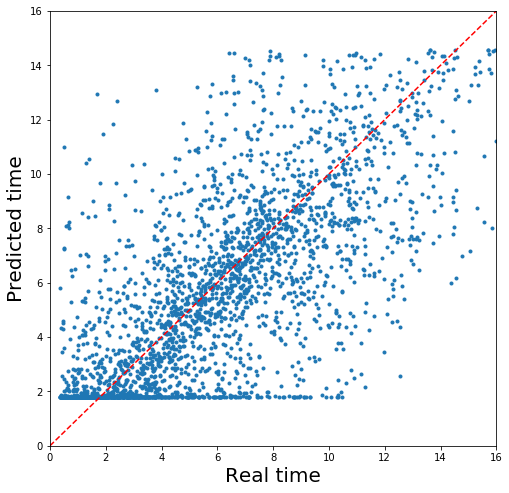

In [11]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test_above,net_above.predict(P_test_above),'.')
ax.plot([0,16],[0,16],'r--')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,16))
ax.set_ylim((0,16))

This network seems to never be able to output predictions with T<1.8 or so. Might be a wrong activation function or output layer.